# Data Wrangling
Date: 09/09/2020                                                  
Version: 1.0

## 1. Introduction
Data cleansing is an iterative process. In this project, we have 3 different data frames that came from the same source, but each one of them has anomalies that must be fixed. This dataset contains transactional retail data from an online electronics store (DigiCO) located in Melbourne, Australia. The store operation is exclusively online, and it has three warehouses around Melbourne from which goods are delivered to customers. The data anomalies can be classified at a high level into three categories and must be found a corrected in each data frame:

**Syntactic Anomalies:** describe characteristics concerning the format and values used for representation of the entities. 
   - Lexical errors
   - Domain format errors 
   - Syntactical error 
   - Irregularities
    
    
**Semantic Anomalies:** hinder the data collection from being a comprehensive and non-redundant representation of the mini-world. 
   - Integrity constraint violations
   - Contradictions
   - Duplicates 
   - Invalid tuples
   
   
**Coverage Anomalies:** decrease the amount of entities and entity properties from the mini-world that are represented in the data collection. 
   - missing values
   - missing tuples


## 2. Import libraries
The perform the wrangling of the data we are going to use the following libraries, to import the information, handle the data frame and plot some results

In [63]:
import pandas as pd
from datetime import datetime
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## 3. Import the data

In [64]:
dirty_data = pd.read_csv('./data/dirty_data.csv')
outlier_data = pd.read_csv('./data/outlier_data.csv')
missing_data = pd.read_csv('./data/missing_data.csv')
warehouses = pd.read_csv('./data/warehouses.csv')



## Dirty Data
The first step is to clean the `dirty_data` data frame. In this case, we must look after **Syntactic Anomalies**


### 1. Examining the data
To do this the first step is to examine the data, to understand the structure of the data frame and the values stored in it. And with this information then be able to identify the anomalies of the data frame.


In [65]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

From the information displayed above, we can observe in the first place that we have a data frame with **500 rows** and **16 columns**. Then we can see the name of each column of the `dirty_data` and identify that there are no missing values in the data frame, as every column has 500 non-null values. Finally, we can observe the data type of each column to categorize them after we look at the values.

In [66]:
dirty_data.head(5)

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD014143,ID0267315670,2019-08-13,Nickolson,"[('Toshika 750', 2), ('iAssist Line', 2), ('pe...",25710,75.23,-37.823454,144.976176,10,23214.23,Winter,True,0.7950,five stars so far i'm very satisfied with my o...,True
1,ORD353742,ID4551628270,2019-10-02,Thompson,"[('Lucent 330S', 2), ('Alcon 10', 2)]",20360,85.06,-37.807665,144.947883,0,20445.06,Spring,True,0.5621,i was a sucker. the phone was good for maybe t...,False
2,ORD146778,ID5680172487,2019-01-23,Thompson,"[('Olivia x460', 1), ('Alcon 10', 2), ('iStrea...",19425,76.88,-37.808919,144.972858,25,14645.63,Summer,False,1.1157,this tablet is simple to set up and it's worth...,True
3,ORD469433,ID0248746951,2019-09-04,Bakers,"[('Thunder line', 2), ('iAssist Line', 2), ('p...",21430,80.02,-37.821793,144.990754,5,20438.52,Spring,False,1.3710,awesome phone we pre ordered.. it felt like fo...,True
4,ORD134238,ID0529158815,2019-11-17,Thompson,"[('Lucent 330S', 1), ('Toshika 750', 1), ('Thu...",7730,106.20,-37.823822,144.940507,15,6676.70,summer,True,1.3686,very happy great performance and amazing batte...,True


### Categorical
The following attributes of the data frame can be categorized into groupes and we can not operate with them.
   - **order_id:** A unique id for each order
   - **customer_id:** A unique id for each customer
   - **nearest_warehouse:** A string denoting the name of the nearest warehouse to the customer
   - **shopping_cart:** A list of tuples representing the order items: first element of the tuple is the item ordered, and the second element is the quantity ordered for such item
   - **season:** A string denoting the season in which the order was placed
   - **is_expedited_delivery:** A boolean denoting whether the customer has requested an expedited delivery
   - **latest_customer_review:** A string representing the latest customer review on his/her most recent order
   - **is_happy_customer:** A boolean denoting whether the customer is a happy customer or had an issue with his/her last order.

In [67]:
dirty_data.describe(include=['O']) # Inspect the categorical data

,order_id,customer_id,date,nearest_warehouse,shopping_cart,season,latest_customer_review
count,500,500,500,500,500,500,500
unique,500,491,281,6,472,8,500
top,ORD368177,ID3212411894,2019-04-08,Thompson,"[('pearTV', 1), ('Toshika 750', 1)]",Autumn,five stars great phone at a great price. it ac...
freq,1,2,6,207,3,128,1


In [68]:
dirty_data[['is_expedited_delivery', 'is_happy_customer']].describe() # Inspect the boolean data

,is_expedited_delivery,is_happy_customer
count,500,500
unique,2,2
top,True,True
freq,270,361


### Numerical
   - **Date:** The date the order was made, given in YYYY-MM-DD format
   - **order_price:** A float denoting the order price in AUD. The order price is the price of items before any discounts nd/or delivery charges are applied.
   - **delivery_charges:** A float representing the delivery charges of the order
   - **customer_lat:** Latitude of the customer’s location
   - **customer_long:** Longitude of the customer’s location
   - **order_total:** A float denoting the total of the order in AUD after all discounts and/or delivery charges are applied.
   - **distance_to_nearest_warehouse:** A float representing the arc distance, in kilometres, between the customer and the nearest warehouse to him/her
   - **coupon_discount:** An integer denoting the percentage discount to be applied to the order_price.

In [69]:
dirty_data.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,500.000000,500.0000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,13545.000000,78.0779,-27.942145,135.095276,10.580000,12170.62002,1.101990
std,7544.153173,14.7604,41.353623,41.352158,8.649464,6593.96163,0.492697
min,580.000000,47.7000,-37.833482,-37.824602,0.000000,581.19000,0.031900
25%,8090.000000,66.6725,-37.818529,144.947416,5.000000,7391.04750,0.755050
50%,12017.500000,77.9050,-37.812150,144.961505,10.000000,11055.53000,1.061600
75%,18555.000000,85.6050,-37.804794,144.976985,15.000000,16628.72250,1.460250
max,46060.000000,120.3500,145.014495,145.017014,25.000000,37823.70000,3.158400




### 2. Indentifying Anomalies
After we examined all the information in the data set, we proceed to identify the possible anomalies of each column. By trying to understand the information displayed in the examination and by taking a closer look at the information with `Exploratory Data Analysis`

As we were told that each row only has 1 anomaly, we are going to create a new dataframe to keep track which rows are already wrangled. To do this we are going to create a dataframe called `original` and it will remain without changes. So we can compare and store in a dataframe called `wrangled` is the value was already wrangled or not.

In [70]:
original = pd.read_csv('./30550971_dirty_data.csv')

#### 2.1 order_id
From the examination showed above we can identify that there are 500 unique values and that each of them occurs only once. We presume that this column needs no wrangling.


#### 2.2 customer_id
As we were told before, each client has its own `customer_id` but each client can order as many times as they want. Therefore, this column may have repeated values, and that is why we find 9 repeated values and some `customer_id` with a frequency of 2. We presume that this column needs no wrangling.

In [71]:
dirty_data['customer_id'].value_counts().loc[lambda x : x>1]

ID3212411894    2
ID0033675617    2
ID0600744906    2
ID4326586174    2
ID0635530384    2
ID0598401524    2
ID4264281401    2
ID0282825814    2
ID1560149566    2
Name: customer_id, dtype: int64

There are 9 clients that ordered more than once

In [72]:
dirty_data['customer_id'].value_counts().loc[lambda x : x>1].shape[0]

9

Is worth it to identify if the customers that ordered more that once have the same `nearest_warehouse` in both orders

In [73]:
dirty_data[['customer_id','nearest_warehouse']][dirty_data.duplicated(['customer_id'],keep=False)].sort_values('customer_id')

,customer_id,nearest_warehouse
32,ID0033675617,Thompson
323,ID0033675617,Thompson
225,ID0282825814,Thompson
140,ID0282825814,Thompson
419,ID0598401524,Nickolson
327,ID0598401524,Nickolson
303,ID0600744906,Nickolson
31,ID0600744906,Nickolson
478,ID0635530384,Thompson
386,ID0635530384,Thompson


#### 2.3 date
By looking at the values that are stored in the column date, we realised that they are `string` format

In [74]:
type(dirty_data.date[0])

str

To make it easier to handle, we have to convert these values to be in format date. But there are different formats of dates, that is why we have the following code, where we identify the different formats of date

In [75]:
date = dirty_data.date
date_time = []

for i in date: # For every date in the column date
    if int(i.split('-')[0]) > 2018: # Split the dates by '-' and see if the first element is the year
        if int(i.split('-')[1]) > 12: # Check if the second element is the day or the month
            date_time.append(datetime.strptime(i, "%Y-%d-%m")) # Apply the corresponding date format
        else:
            date_time.append(datetime.strptime(i, "%Y-%m-%d")) # Apply the corresponding date format
            
    elif int(i.split('-')[1]) > 2018: # Split the dates by '-' and see if the second element is the year
        if int(i.split('-')[0]) > 12: # Check if the first element is the day or the month
            date_time.append(datetime.strptime(i, "%d-%Y-%m")) # Apply the corresponding date format
        else:
            date_time.append(datetime.strptime(i, "%m-%Y-%d")) # Apply the corresponding date format
    
    else:
        if int(i.split('-')[0]) > 12:
            date_time.append(datetime.strptime(i, "%d-%m-%Y")) # Apply the corresponding date format
        else:
            date_time.append(datetime.strptime(i, "%m-%d-%Y")) # Apply the corresponding date format

Finally, having all the values of the column in datetime format we replace the values of the column

In [76]:
dirty_data.date = date_time

And now we check that the data is in datetime format

In [77]:
type(dirty_data.date[0])

pandas._libs.tslibs.timestamps.Timestamp

Finally, to keep track of which rows are already wrangled we build a dataframe with the comparison between the original values and the wrangled values. If both values are equal it means that it was not wrangled and the value in `df_wrangling` will be **False** for this value. Otherwise it will be **True**

In [78]:
wrangled = []
for i in range(500):
    if str(dirty_data.date[i])[:10] == str(original.date[i]):
        wrangled.append(False)
    else:
        wrangled.append(True)

wrangled_dict = {'date': wrangled}
df_wrangling = pd.DataFrame(wrangled_dict)

#### 2.4 season
We know that there are only 4 seasons: Summer, Winter, Autum and Spring. But when we look clasely there are 8 different seasons, and that is why we need to look at this column closer

In [79]:
dirty_data.season.value_counts()

Autumn    128
Summer    125
Winter    121
Spring    110
autumn      7
summer      4
winter      3
spring      2
Name: season, dtype: int64

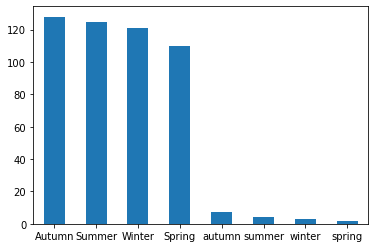

In [80]:
dirty_data.season.value_counts().plot.bar(rot=0)

As the column `nearest_warehouse`, here we have some lexical errors. So we must replace some values in order to keep the unique values of seasons.

In [81]:
dirty_data.season.replace({'autumn':'Autumn', 'summer':'Summer', 'winter':'Winter', 'spring':'Spring'},inplace=True)

After the replacements we observe that there are only four seasons

In [82]:
dirty_data.season.value_counts()

Autumn    135
Summer    129
Winter    124
Spring    112
Name: season, dtype: int64

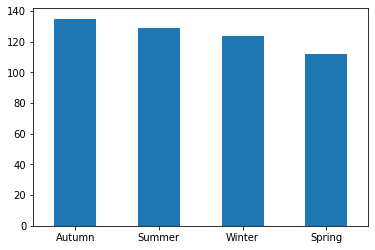

In [83]:
dirty_data.season.value_counts().plot.bar(rot=0)

Now that we corrected the lexical errors we have to check the seasons against months. Following the guidance of the Bureau of Metheorology, in Australia the seasons are defined by grouping the calendar months in the following way:

   - **Spring:** the three transition months September, October and November.
   - **Summer:** the three hottest months December, January and February.
   - **Autumn:** the transition months March, April and May.
   - **Winter:** the three coldest months June, July and August.

In [84]:
months = pd.DatetimeIndex(dirty_data['date']).month
crosstab = pd.crosstab(months,dirty_data['season'])
crosstab

season,Autumn,Spring,Summer,Winter
row_0,,,,
1,0,1,46,0
2,1,0,37,2
3,48,1,1,0
4,40,0,0,0
5,38,0,0,1
6,2,1,1,43
7,0,1,0,39
8,1,0,1,36
9,2,44,0,0


Text(0, 0.5, 'Frequency')

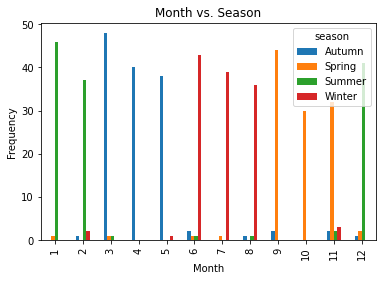

In [85]:
plot = crosstab.plot.bar(title='Month vs. Season')
plot.set_xlabel("Month")
plot.set_ylabel("Frequency")

From the `cross table` and the `bar plot` we can identify that there are some tuples, where the season does not correspond to the month of the sale. That is why we proceed to change the `season` accordingly to the month of the sale.

In [86]:
for i in range(1, 13): # For every month of the year
    if i in [9, 10, 11]: # Spring if Septembre, October or November
        dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Spring'
    if i in [12, 1, 2]: # Summer if December, January or February
        dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Summer'
    if i in [3, 4, 5]: # Autumn if March, April or May
        dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Autumn'
    if i in [6, 7, 8]: # Winter if June, July or August
        dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Winter'

<ipython-input-86-d37b63598468>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Summer'
<ipython-input-86-d37b63598468>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_data['season'][pd.DatetimeIndex(dirty_data['date']).month == i] = 'Autumn'
<ipython-input-86-d37b63598468>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_data['season'][pd.DatetimeIn

And now, we have corrected the errors in the column `season`

In [87]:
months = pd.DatetimeIndex(dirty_data['date']).month
crosstab = pd.crosstab(months,dirty_data['season'])
crosstab

season,Autumn,Spring,Summer,Winter
row_0,,,,
1,0,0,47,0
2,0,0,40,0
3,50,0,0,0
4,40,0,0,0
5,39,0,0,0
6,0,0,0,47
7,0,0,0,40
8,0,0,0,38
9,0,46,0,0


Text(0, 0.5, 'Frequency')

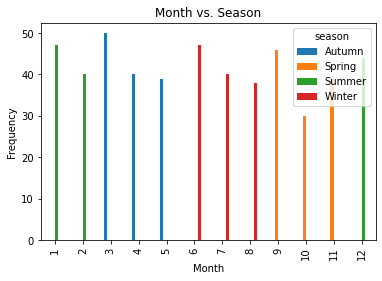

In [88]:
plot = crosstab.plot.bar(title='Month vs. Season')
plot.set_xlabel("Month")
plot.set_ylabel("Frequency")

That is why we proceed to change the seasons according to the month of sale

Finally, we perform the comparison with the original values. And append the results to the dataframe `df_wrangling` with the same column name.

In [89]:
wrangled = []
for i in range(500):
    if dirty_data.season[i] == original.season[i]:
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['season'] = wrangled

#### 2.5 Coordinates 
`columns: customer_lat and customer_long`

From the quantiles of each column we can observe that there are some rare values (outliers) so we can take a closer look to it and understand the meaning of these outliers

In [90]:
coord = dirty_data[['customer_lat', 'customer_long']]
coord.describe()

,customer_lat,customer_long
count,500.000000,500.000000
mean,-27.942145,135.095276
std,41.353623,41.352158
min,-37.833482,-37.824602
25%,-37.818529,144.947416
50%,-37.812150,144.961505
75%,-37.804794,144.976985
max,145.014495,145.017014


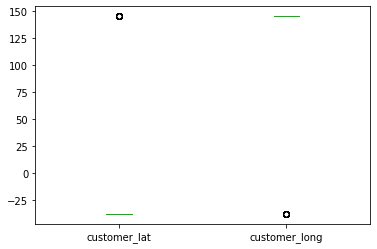

In [91]:
coord.plot.box()

By looking at the previous graph, we can see that the outliers of each column are at the same height as the values of the other column. Therefore, it is possible that the person in charge of filling in the values in the table may have swapped the columns.

In [92]:
coord[coord.customer_lat > -37].shape[0]

27

In [93]:
coord[coord.customer_long < 144].shape[0]

27

And then we can confirm that there are 27 swapped coordinates that need to be fixed with the following code

In [94]:
lat_list = coord['customer_lat'].to_list()  # Convert the column to a list
long_list = coord['customer_long'].to_list()  # Convert the column to a list
new_lat = []
new_long = []

for i in range(len(lat_list)):  # For every value in the list
    if lat_list[i] < -37:  # if the latitude is lower than -37
        new_lat.append(lat_list[i])  # keep this value as latitude
    else:
        new_lat.append(long_list[i])  # Swap the value with the longitude
        
    
    if long_list[i] > 144:  # if the longitude is greatter than 144
        new_long.append(long_list[i])  # keep this value as longitude
    else:
        new_long.append(lat_list[i]) # Swap the value with the latitude

After we get the lists with the correct coordinates we proceed to replace the values of the columns of the original dataframe

In [95]:
dirty_data['customer_lat'] = new_lat
dirty_data['customer_long'] = new_long

And then with this swap there are not outliers anymore

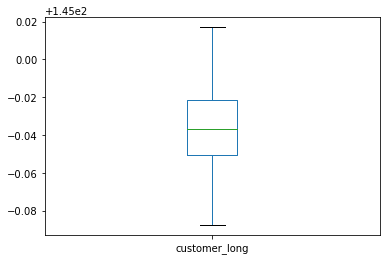

In [96]:
dirty_data.customer_long.plot.box()

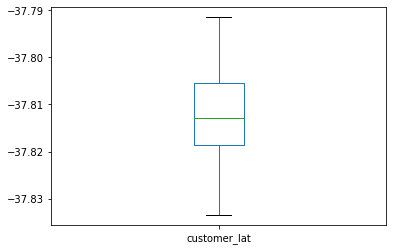

In [97]:
dirty_data.customer_lat.plot.box()

In [98]:
dirty_data[['customer_lat', 'customer_long']].describe()

,customer_lat,customer_long
count,500.000000,500.000000
mean,-37.812391,144.965522
std,0.007877,0.021070
min,-37.833482,144.912433
25%,-37.818662,144.949209
50%,-37.812910,144.963283
75%,-37.805467,144.978802
max,-37.791484,145.017014


Finally, we perform the comparison with the original values. And append the results to the dataframe `df_wrangling` with the same column name.

In [99]:
wrangled = []
for i in range(500):
    if dirty_data.customer_lat[i] == original.customer_lat[i]:
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['customer_lat'] = wrangled

In [100]:
wrangled = []
for i in range(500):
    if dirty_data.customer_long[i] == original.customer_long[i]:
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['customer_long'] = wrangled

#### 2.6 Warehouses
`columns: distance_to_nearest_warehouse and nearest_warehouse`

Having the coordinates of each customer and the coordinates of each warehouse we can calculate the distance between them, and then we can select the smallest one. Therefore, we are going to calculate the distance between the customers and the warehouses using a function called `haversine` (radius of earth: 6378 km). By doing this calculation we can also wrangle the column `nearest_warehouse`

We create a dictionary with the radian coordinates of each warehouse

In [101]:
warehouse = warehouses[['lat', 'lon']].apply(list, axis=1).tolist() 
warehouse_dict = {'Nickolson': [radians(i) for i in warehouse[0]], 'Thompson': [radians(i) for i in warehouse[1]], 
                  'Bakers': [radians(i) for i in warehouse[2]]} # Store the coord of each warehouse as radians in a dict
warehouse_dict

{'Nickolson': [-0.660059001228265, 2.530195980087838],
 'Thompson': [-0.6599556463206203, 2.5298035934200755],
 'Bakers': [-0.6599089221112152, 2.5306441980930434]}

Afterwards, we create a new dataframe with the `customer_id` and the distance to each warehouse

In [102]:
customer_coord = dirty_data[['customer_id','customer_lat', 'customer_long']] # New df with coordinates of each customer

customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
customer_coord['coordinates'] = customer_coord[['customer_lat', 'customer_long']].apply(list, axis=1) # Create a list with lat and Long of each customer

for wh in warehouse_dict: # For every warehouse
    distance = [] # Empty list to store the distances between the customer and the warehouses
    for coord in customer_coord['coordinates']: # For every customer coordinates
        distance.append(haversine_distances([warehouse_dict[wh], coord])[0][1]* 6378000/1000) # Calculate the distance
    
    customer_coord[wh] = distance # Create a new column called as the warehouse to store the distance

customer_coord = customer_coord[['customer_id', 'Nickolson', 'Thompson', 'Bakers']] # Only get the columns that matters
customer_coord.head(10)

<ipython-input-102-be6d4d071822>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
<ipython-input-102-be6d4d071822>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
<ipython-input-102-be6d4d071822>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,customer_id,Nickolson,Thompson,Bakers
0,ID0267315670,0.794954,2.826958,2.247742
1,ID4551628270,2.260867,0.562085,4.172318
2,ID5680172487,1.115684,2.306235,1.971329
3,ID0248746951,1.898174,3.973460,1.371004
4,ID0529158815,2.619340,1.368641,5.052488
5,ID4518640804,2.701037,0.720226,4.665057
6,ID0248746953,1.953342,4.014536,1.210869
7,ID0128977294,0.545213,1.538853,2.885935
8,ID0250480669,3.013058,4.865224,0.630150
9,ID4315827374,2.587747,4.629393,1.135126


Finally, we get the shortest distance and the name of the warehouse as the values we were looking for. We create a dataframe with this information and the perform a left join with `dirty_data` with customer_id as the key

In [103]:
cust_distance = customer_coord[['customer_id']] # Create a new dataframe with the customer_id as the key
cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse
cust_distance['nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].idxmin(axis=1) # Get the warehouse with the lowest distance
cust_distance.drop_duplicates(subset=['customer_id'], keep='last', inplace=True) # Remove duplicate customers
cust_distance.head(10)

<ipython-input-103-ef25988df9fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse
<ipython-input-103-ef25988df9fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_distance['nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].idxmin(axis=1) # Get the warehouse with the lowest distance
<ipython-input-103-ef

,customer_id,distance_to_nearest_warehouse,nearest_warehouse
0,ID0267315670,0.794954,Nickolson
1,ID4551628270,0.562085,Thompson
2,ID5680172487,1.115684,Nickolson
3,ID0248746951,1.371004,Bakers
4,ID0529158815,1.368641,Thompson
5,ID4518640804,0.720226,Thompson
6,ID0248746953,1.210869,Bakers
7,ID0128977294,0.545213,Nickolson
8,ID0250480669,0.630150,Bakers
9,ID4315827374,1.135126,Bakers


Now that we have the df, we drop the columns `distance_to_nearest_warehouse` and `nearest_warehouse` from `dirty_data` and the we perform the left join. To not have duplicate columns.

In [104]:
dirty_data.drop(columns=['distance_to_nearest_warehouse', 'nearest_warehouse'], inplace=True) # remove old columns 
dirty_data = pd.merge(dirty_data, cust_distance, left_on='customer_id', right_on='customer_id', how='left') # Left join the columns with the new a wrangle data

By wrangling the column `distance_to_nearest_warehouse` we already wrangle the column `nearest_warehouse` too. As we can see as follows

In [105]:
dirty_data.nearest_warehouse.value_counts()

Thompson     217
Nickolson    181
Bakers       102
Name: nearest_warehouse, dtype: int64

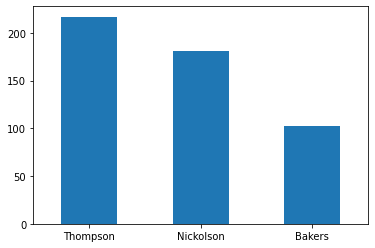

In [106]:
dirty_data.nearest_warehouse.value_counts().plot.bar(rot=0)

Finally, we perform the comparison with the original values. And append the results to the dataframe `df_wrangling` with the same column name.

In [107]:
wrangled = []
for i in range(500):
    if dirty_data.nearest_warehouse[i] == original.nearest_warehouse[i]:
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['nearest_warehouse'] = wrangled

In [108]:
wrangled = []
for i in range(500):
    if round(dirty_data.distance_to_nearest_warehouse[i]) == round(original.distance_to_nearest_warehouse[i]):
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['distance_to_nearest_warehouse'] = wrangled

In [109]:
df_wrangling.distance_to_nearest_warehouse.value_counts()

False    486
True      14
Name: distance_to_nearest_warehouse, dtype: int64

#### 2.7 Customer feeling
`columns: is_happy_customer and latest_customer_review`

We have a column that is called `is_happy_customer`that is closely linked to the value of `latest_customer_review`. The data of the reviews of the customer will remain the same, but it will help us to identify if the customer is happy or not. 

We can check that by analysing the sentiment of each review, by using the library `SentimentIntensityAnalyzer`. If we find that the polarity of the review is equal or higher that 0.05, we classify it as **Happy**. But if the polarity is lower than 0.05 it will be classified as **Not Happy**

In [110]:
reviews = dirty_data['latest_customer_review'].to_list() # Convert the column review to a list
sentiment = SentimentIntensityAnalyzer() # Import the sentiment analyzer
is_happy = [] # Create an empty list where we are going to store if the customer is happy or not

for review in reviews: # For every review of the dataframe
    if sentiment.polarity_scores(review)['compound'] >= 0.05: # If the polarity score of the review is equal or higher than 0.05
        is_happy.append(True) # The customer is happy
    else:
        is_happy.append(False) # The customer is not happy

Before replacing the new values of the column `is_happy_customer`. We can observe the details of the column

True     361
False    139
Name: is_happy_customer, dtype: int64

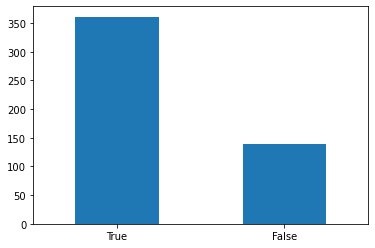

In [111]:
dirty_data['is_happy_customer'].value_counts().plot.bar(rot=0)
dirty_data['is_happy_customer'].value_counts()

After we have the list with the real feeling of each customer, we can replace the values of `latest_customer_review` from the dataframe `dirty_data`, and observe the changes of this column

True     377
False    123
Name: is_happy_customer, dtype: int64

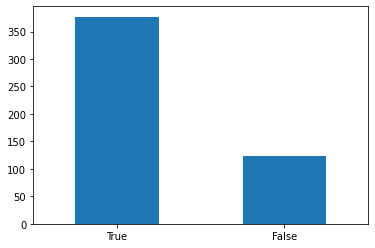

In [112]:
dirty_data['is_happy_customer'] = is_happy
dirty_data['is_happy_customer'].value_counts().plot.bar(rot=0)
dirty_data['is_happy_customer'].value_counts()

We can observe that after the changes made, we have 16 more happy clients

Finally, we perform the comparison with the original values. And append the results to the dataframe `df_wrangling` with the same column name.

In [113]:
wrangled = []
for i in range(500):
    if dirty_data.is_happy_customer[i] == original.is_happy_customer[i]:
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['is_happy_customer'] = wrangled

#### 2.7 price of items
`columns: shopping_cart and order_price`

Knowing that the dataframe only has one anomaly per row, we identify the rows that are already wrangled and get a new dataframe to extract the information required to solve the linear equations and get the value of each prodcut and verify the `order_price` column

In [114]:
shopping_list = dirty_data.shopping_cart[df_wrangling.customer_lat == True].to_list() # Get the rows that were wrangled
price_list = dirty_data.order_price[df_wrangling.customer_lat == True].to_list() # Get the rows that were wrangled

products_list = [] # Empty list to identify all the different products that the store sells
equations = [] # Empty list to store all the equations to solve the linear solution
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i) # Find every text between (' and ',
    
    for product in products: # for every product found by the Regular Expression
        if product not in products_list: # Build a list with all the different products found
            products_list.append(product)   
        

for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    equation = [0]*10 # Build a list of 10 elements all of them 0
    for j in range(len(products)): # For every element in products
        for k in range(len(products_list)): # for every element in products_list
            if products[j] == products_list[k]: # If the elements are equal
                equation[k] = quantity[j] # Assign the quantity of each product to the list equantion
    
    equations.append(equation) # Append all the equations together           

Now that we already have the equations and the solution to it, we can procced to solve the problem using the lubrary numpy

In [115]:
eq = np.array(equations[1:11])
res = np.array(price_list[1:11])
solution = np.linalg.solve(eq, res)

And construct a dictionary `product_price` where we can store the price of each product

In [116]:
product_price = {}
for i in range(len(solution)):
    product_price[products_list[i]] = round(solution[i])

product_price

{'Toshika 750': 4320.0,
 'Lucent 330S': 1230.0,
 'pearTV': 6310.0,
 'Candle Inferno': 430.0,
 'Alcon 10': 8950.0,
 'Thunder line': 2180.0,
 'iAssist Line': 2225.0,
 'Universe Note': 3450.0,
 'Olivia x460': 1225.0,
 'iStream': 150.0}

With this dictionary, now we know the price of each product. So we can correct the column `order_price`

In [117]:
shopping_list = dirty_data.shopping_cart.to_list()

order_price = []
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    total = 0
    for j in range(len(products)): # For every element in products
        for k in product_price: # for every element in products_list
            if products[j] == k:
                total += product_price[k]*quantity[j]
    
    order_price.append(total)

dirty_data['order_price'] = order_price

Finally, we perform the comparison with the original values. And append the results to the dataframe `df_wrangling` with the same column name.

In [118]:
wrangled = []
for i in range(500):
    if round(dirty_data.order_price[i]) == round(original.order_price[i]):
        wrangled.append(False)
    else:
        wrangled.append(True)

df_wrangling['order_price'] = wrangled

#### 3. Summary
Finally, after wrangle all the values of the dataframe we obtain the following statistics:

In [119]:
df_wrangling.apply(pd.value_counts)

,date,season,customer_lat,customer_long,nearest_warehouse,distance_to_nearest_warehouse,is_happy_customer,order_price
False,473,468,473,473,473,486,472,446
True,27,32,27,27,27,14,28,54


True values are the number of rows that were wrangled per column

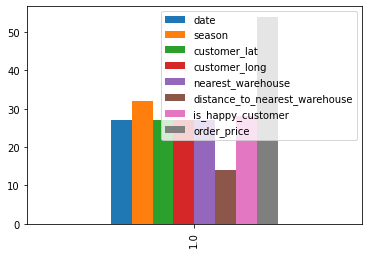

In [120]:
df_wrangling[df_wrangling == True].apply(pd.value_counts).plot.bar()

Now that the dataframe is wrangled, we proceed to export the solution to the new cav file

In [121]:
dirty_data.to_csv('./output/dirty_data_solution.csv')

## Missing Data
The second step is to clean the `missing_data` data frame. In this case, we must look after **Missing Values**


### 1. Examining the data
To do this the first step is to examine the data, to know where are the missing values of the dataframe.

In [122]:
missing_data.isnull().sum()

order_id                          0
customer_id                       0
date                              0
nearest_warehouse                55
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse    31
latest_customer_review            0
is_happy_customer                40
dtype: int64

### 2. Imputing the data
Now that we already identify which values must be imputed, we proceed to do it

#### 2.1 Warehouse
`columns: nearest_warehouse and distance_to_nearest_warehouse`

With the coordinates of each customer and the coordinates of each warehouse. We can calculate the missing values of `distance_to_nearest_warehouse` and `nearest_warehouse` 

We create a dictionary with the radian coordinates of each warehouse

In [123]:
warehouse = warehouses[['lat', 'lon']].apply(list, axis=1).tolist() 
warehouse_dict = {'Nickolson': [radians(i) for i in warehouse[0]], 'Thompson': [radians(i) for i in warehouse[1]], 
                  'Bakers': [radians(i) for i in warehouse[2]]} # Store the coord of each warehouse as radians in a dict
warehouse_dict

{'Nickolson': [-0.660059001228265, 2.530195980087838],
 'Thompson': [-0.6599556463206203, 2.5298035934200755],
 'Bakers': [-0.6599089221112152, 2.5306441980930434]}

Afterwards, we create a new dataframe with the `customer_id` and the distance to each warehouse

In [124]:
customer_coord = missing_data[['customer_id','customer_lat', 'customer_long']] # New df with coordinates of each customer

customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
customer_coord['coordinates'] = customer_coord[['customer_lat', 'customer_long']].apply(list, axis=1) # Create a list with lat and Long of each customer

for wh in warehouse_dict: # For every warehouse
    distance = [] # Empty list to store the distances between the customer and the warehouses
    for coord in customer_coord['coordinates']: # For every customer coordinates
        distance.append(haversine_distances([warehouse_dict[wh], coord])[0][1]* 6378000/1000) # Calculate the distance
    
    customer_coord[wh] = distance # Create a new column called as the warehouse to store the distance

customer_coord = customer_coord[['customer_id', 'Nickolson', 'Thompson', 'Bakers']] # Only get the columns that matters
customer_coord.head(10)

<ipython-input-124-aaa48d0ae777>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
<ipython-input-124-aaa48d0ae777>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
<ipython-input-124-aaa48d0ae777>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,customer_id,Nickolson,Thompson,Bakers
0,ID1838361782,0.326076,1.802831,2.585441
1,ID0257503162,2.186224,1.903192,3.162137
2,ID0589426084,1.051861,2.278012,1.986674
3,ID0207085804,4.174217,6.057580,1.817847
4,ID0589306701,0.740102,2.272516,1.982864
5,ID0060095426,1.814682,3.897019,1.730161
6,ID3191033052,0.820767,2.212779,2.033702
7,ID0781149924,2.956862,1.211140,4.671327
8,ID1838361782,0.326076,1.802831,2.585441
9,ID5001030293,1.716981,0.508507,3.760656


Finally, we get the shortest distance and the name of the warehouse as the values we were looking for. We create a dataframe with this information and the perform a left join with `missing_data` with customer_id as the key

In [125]:
cust_distance = customer_coord[['customer_id']] # Create a new dataframe with the customer_id as the key
cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse
cust_distance['nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].idxmin(axis=1) # Get the warehouse with the lowest distance
cust_distance.drop_duplicates(subset=['customer_id'], keep='last', inplace=True) # Remove duplicate customers
cust_distance.head(10)

<ipython-input-125-ef25988df9fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse
<ipython-input-125-ef25988df9fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_distance['nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].idxmin(axis=1) # Get the warehouse with the lowest distance
<ipython-input-125-ef

,customer_id,distance_to_nearest_warehouse,nearest_warehouse
1,ID0257503162,1.903192,Thompson
2,ID0589426084,1.051861,Nickolson
3,ID0207085804,1.817847,Bakers
4,ID0589306701,0.740102,Nickolson
5,ID0060095426,1.730161,Bakers
6,ID3191033052,0.820767,Nickolson
7,ID0781149924,1.211140,Thompson
8,ID1838361782,0.326076,Nickolson
9,ID5001030293,0.508507,Thompson
10,ID6167417925,1.001135,Thompson


As we already create our own dataframe with the values of `distance_to_nearest_warehouse` and `nearest_warehouse`. We drop these columns and replace the values with a **left join** with `customer_id` as the key

In [126]:
missing_data.drop(columns=['distance_to_nearest_warehouse', 'nearest_warehouse'], inplace=True) # remove old columns 
missing_data = pd.merge(missing_data, cust_distance, left_on='customer_id', 
                        right_on='customer_id', how='left') # Left join the columns with the new a wrangle data

And now we can see that there are no missing values in `distance_to_nearest_warehouse` and `nearest_warehouse`

In [127]:
missing_data.isnull().sum()

order_id                          0
customer_id                       0
date                              0
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
latest_customer_review            0
is_happy_customer                40
distance_to_nearest_warehouse     0
nearest_warehouse                 0
dtype: int64

#### 2.2 is_happy_customer

We have a some missing value is the column `is_happy_customer` but this value is closely linked to the value of `latest_customer_review`. 

We can check that by analysing the sentiment of each review, by using the library `SentimentIntensityAnalyzer`. If we find that the polarity of the review is equal or higher that 0.05, we classify it as **Happy**. But if the polarity is lower than 0.05 it will be classified as **Not Happy**

In [128]:
reviews = missing_data['latest_customer_review'].to_list() # Convert the column review to a list
sentiment = SentimentIntensityAnalyzer() # Import the sentiment analyzer
is_happy = [] # Create an empty list where we are going to store if the customer is happy or not

for review in reviews: # For every review of the dataframe
    if sentiment.polarity_scores(review)['compound'] >= 0.05: # If the polarity score of the review is equal or higher than 0.05
        is_happy.append(True) # The customer is happy
    else:
        is_happy.append(False) # The customer is not happy

missing_data['is_happy_customer'] = is_happy

With these changes we can see tht there are no missing values in the column `is_happy_customer `

In [129]:
missing_data.isnull().sum()

order_id                          0
customer_id                       0
date                              0
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
latest_customer_review            0
is_happy_customer                 0
distance_to_nearest_warehouse     0
nearest_warehouse                 0
dtype: int64

#### 2.3 Price
`columns: order_price, order_total`

We know that all the data in the the data frame is correct, therefore we can perform a linear equation solve for the items in the `shopping cart`. Thus, know the price of each item in the cart. 

With these prices we can get the `order_price` and `order_total`

$$\text{order_total} = \left(\text{order_price}*\text{coupon_discount}\right) + \text{delivery_charges}$$

In [130]:
shopping_list = missing_data.shopping_cart[missing_data.order_price.notnull()].to_list() # Get the rows that were wrangled
price_list = missing_data.order_price[missing_data.order_price.notnull()].to_list() # Get the rows that were wrangled

products_list = [] # Empty list to identify all the different products that the store sells
equations = [] # Empty list to store all the equations to solve the linear solution
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i) # Find every text between (' and ',
    
    for product in products: # for every product found by the Regular Expression
        if product not in products_list: # Build a list with all the different products found
            products_list.append(product)   
        

for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    equation = [0]*10 # Build a list of 10 elements all of them 0
    for j in range(len(products)): # For every element in products
        for k in range(len(products_list)): # for every element in products_list
            if products[j] == products_list[k]: # If the elements are equal
                equation[k] = quantity[j] # Assign the quantity of each product to the list equantion
    
    equations.append(equation) # Append all the equations together           

Now that we already have the equations and the solution to it, we can procced to solve the problem using the lubrary numpy

In [131]:
eq = np.array(equations[8:18])
res = np.array(price_list[8:18])
solution = np.linalg.solve(eq, res)

And construct a dictionary `product_price` where we can store the price of each product

In [132]:
product_price = {}
for i in range(len(solution)):
    product_price[products_list[i]] = round(solution[i])

product_price

{'Alcon 10': 8950.0,
 'iAssist Line': 2225.0,
 'iStream': 150.0,
 'Universe Note': 3450.0,
 'Toshika 750': 4320.0,
 'Candle Inferno': 430.0,
 'Olivia x460': 1225.0,
 'pearTV': 6310.0,
 'Lucent 330S': 1230.0,
 'Thunder line': 2180.0}

With this dictionary, now we know the price of each product. So we can correct the column `order_price`

In [133]:
shopping_list = missing_data.shopping_cart[missing_data.order_price.isnull()].to_list()

order_price = []
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    total = 0
    for j in range(len(products)): # For every element in products
        for k in product_price: # for every element in products_list
            if products[j] == k:
                total += product_price[k]*quantity[j]
    
    order_price.append(total)

missing_data.order_price[missing_data.order_price.isnull()] = order_price

<ipython-input-133-bb6a8c750593>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data.order_price[missing_data.order_price.isnull()] = order_price


In [134]:
missing_data.isnull().sum()

order_id                          0
customer_id                       0
date                              0
shopping_cart                     0
order_price                       0
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
latest_customer_review            0
is_happy_customer                 0
distance_to_nearest_warehouse     0
nearest_warehouse                 0
dtype: int64

Now that the dataframe is wrangled, we proceed to export the solution to the new cav file

In [135]:
missing_data.to_csv('./output/missing_data_solution.csv')

## Outlier Data
The third step is to clean the `outlier_data` data frame. In this case, we must look after **Outliers**


### 1. Examining the data
To do this the first step is to examine the data, to know where are the outliers of the dataframe.

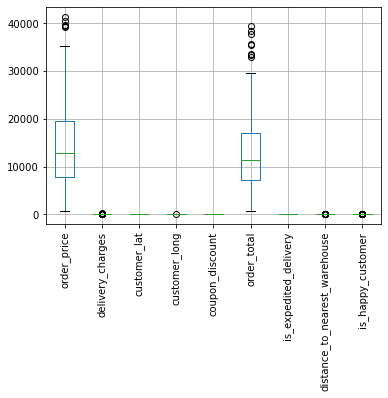

In [136]:
outlier_data.boxplot(rot=90)

With these boxplot we can determine which columns are numeric and would need a closer look in order to understand the outliers in each of them.

### 2. Analyzing and Cleaning the data
Now that we already identify which columns may have outliers, we proceed to take a closer look

#### 2.1 is_happy_customer
Even though it seems that this column may have outliers, we must know that for **Python** True statement is understood as 1 and False as 0. Therefore, in this column we only must have these values but it is not a numeric series. 

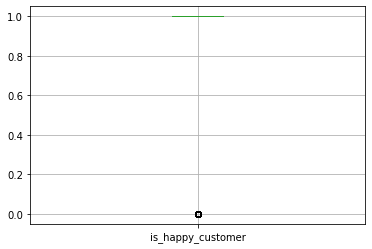

In [137]:
outlier_data.boxplot(column='is_happy_customer')

#### 2.2 is_expedited_delivery
In this column we can see the same pattern as `is_happy_customer`. Therefore, we do not have to wrangl this column either

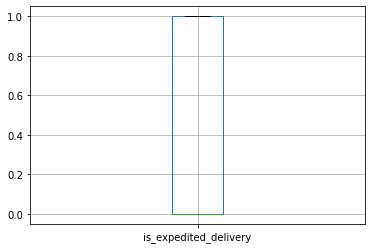

In [138]:
outlier_data.boxplot(column='is_expedited_delivery')

#### 2.3 coupon_discount
By using the method of the Interquartile Range we observe that there are not outliers in this column. We calculate that by 2 different ways, the first one is the boxplot.

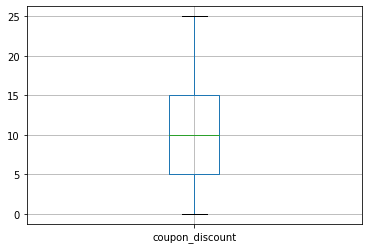

In [139]:
outlier_data.boxplot(column='coupon_discount')

The second one is using the following formula

$$Outlier_{\text{upper}} > Q3 + 1.5*IQR$$
$$Outlier_{\text{lower}} < Q1 - 1.5*IQR$$

In [140]:
outlier_data.coupon_discount.describe()

count    500.000000
mean      10.650000
std        8.471779
min        0.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       25.000000
Name: coupon_discount, dtype: float64

In [141]:
q1 = outlier_data.coupon_discount.quantile(0.25)
q3 = outlier_data.coupon_discount.quantile(0.75)
IQR = q3 - q1

In [142]:
upper_boundary = q3 + (1.5*IQR)
lower_boundary = q1 - (1.5*IQR)

Using the formula we realize that there are not values bigger than the upper boundary of outliers

In [143]:
outlier_data.coupon_discount[outlier_data.coupon_discount > upper_boundary]

Series([], Name: coupon_discount, dtype: int64)

Neither, lower than the lower boundary

In [144]:
outlier_data.coupon_discount[outlier_data.coupon_discount < lower_boundary]

Series([], Name: coupon_discount, dtype: int64)

#### 2.4 Coordinates
`columns: customer_lat and customer_long`

From the following analysis, we observe that only the column `customer_long` presents outliers.

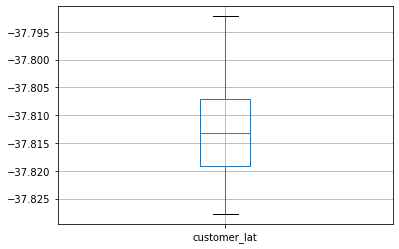

In [145]:
outlier_data.boxplot(column='customer_lat')

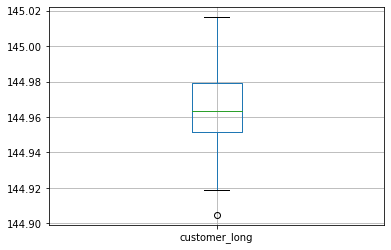

In [146]:
outlier_data.boxplot(column='customer_long')

As we can not take a closer look to the coordinates, as we do not have more information about the customers. We can plot both latitude and longitude in a scatter plot, and see if there is any point that seems to far from the other ones

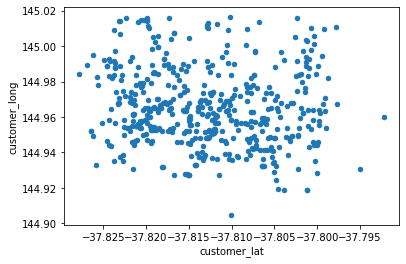

In [147]:
outlier_data.plot.scatter('customer_lat', 'customer_long')

And we found that the outlier of longitude is a customer that lives a little far to the south from the other customers. But it still seems to live in a reasonable range. That is why we consider that this value is not an outlier

#### 2.5 distance_to_nearest_warehouse

From the boxplot, we observe that there are some values that are outliers

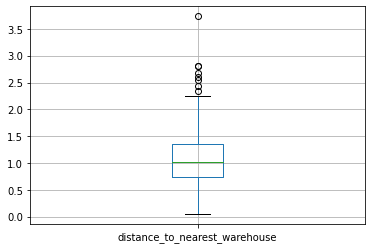

In [148]:
outlier_data.boxplot(column='distance_to_nearest_warehouse')

Using the formula of IQR shown before, we are going to inspect those values and see if there is a mistake or it is correct

$$Outlier_{\text{upper}} > Q3 + 1.5*IQR$$
$$Outlier_{\text{lower}} < Q1 - 1.5*IQR$$

In [149]:
outlier_data.distance_to_nearest_warehouse.describe()

count    500.000000
mean       1.070063
std        0.519719
min        0.050400
25%        0.731800
50%        1.020250
75%        1.358875
max        3.733000
Name: distance_to_nearest_warehouse, dtype: float64

In [150]:
q1 = outlier_data.distance_to_nearest_warehouse.quantile(0.25)
q3 = outlier_data.distance_to_nearest_warehouse.quantile(0.75)
IQR = q3 - q1

In [151]:
upper_boundary = q3 + (1.5*IQR)
lower_boundary = q1 - (1.5*IQR)

Using the formula we realize that there are some clients that are quite far from the nearest warehouse. That is why we want to make a closer look to those values

In [152]:
lower_outlier_distance = outlier_data[outlier_data.distance_to_nearest_warehouse < lower_boundary]
len(lower_outlier_distance)

0

There are not values below the lower boundary

In [153]:
upper_outlier_distance = outlier_data[outlier_data.distance_to_nearest_warehouse > upper_boundary]
len(upper_outlier_distance)

8

As we found 8 values above the upper boundary we proceed to recalculate the distance from the customer to the closest warehouse. With the dictionary with the radian coordinates of each warehouse we can calculate it

In [154]:
warehouse = warehouses[['lat', 'lon']].apply(list, axis=1).tolist() 
warehouse_dict = {'Nickolson': [radians(i) for i in warehouse[0]], 'Thompson': [radians(i) for i in warehouse[1]], 
                  'Bakers': [radians(i) for i in warehouse[2]]} # Store the coord of each warehouse as radians in a dict
warehouse_dict

{'Nickolson': [-0.660059001228265, 2.530195980087838],
 'Thompson': [-0.6599556463206203, 2.5298035934200755],
 'Bakers': [-0.6599089221112152, 2.5306441980930434]}

Afterwards, we create a new dataframe with the `customer_id` and the distance to each warehouse

In [155]:
customer_coord = upper_outlier_distance[['customer_id','customer_lat', 'customer_long']] # New df with coordinates of each customer

customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
customer_coord['coordinates'] = customer_coord[['customer_lat', 'customer_long']].apply(list, axis=1) # Create a list with lat and Long of each customer

for wh in warehouse_dict: # For every warehouse
    distance = [] # Empty list to store the distances between the customer and the warehouses
    for coord in customer_coord['coordinates']: # For every customer coordinates
        distance.append(round((haversine_distances([warehouse_dict[wh], coord])[0][1]* 6378000/1000),4)) # Calculate the distance

    customer_coord[wh] = distance # Create a new column called as the warehouse to store the distance

customer_coord = customer_coord[['customer_id', 'Nickolson', 'Thompson', 'Bakers']] # Only get the columns that matters
customer_coord

<ipython-input-155-04d83f547aa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_lat'] = customer_coord['customer_lat'].apply(radians) # Convert the latitud to radians
<ipython-input-155-04d83f547aa4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_coord['customer_long'] = customer_coord['customer_long'].apply(radians) # Convert the longitude to radians
<ipython-input-155-04d83f547aa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,customer_id,Nickolson,Thompson,Bakers
85,ID0055118298,3.0536,2.5473,3.6743
133,ID0202690490,4.7618,2.6794,6.7635
176,ID0202417498,4.8780,2.8078,6.8055
236,ID3529934922,5.7775,3.7330,7.9573
243,ID0580179508,4.2950,2.4277,5.8974
277,ID1287222258,2.3343,2.4457,2.8041
332,ID0373645741,4.6795,2.5961,6.6967
370,ID0202417498,4.8780,2.8078,6.8055


Finally, we get the shortest distance and the name of the warehouse as the values we were looking for. We create a dataframe with this information and the perform a left join with `outlier_data` with customer_id as the key

In [156]:
cust_distance = customer_coord[['customer_id']] # Create a new dataframe with the customer_id as the key
cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse
cust_distance

<ipython-input-156-ae1bf2815c0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_distance['distance_to_nearest_warehouse'] = customer_coord[['Nickolson', 'Thompson', 'Bakers']].min(axis=1).to_list() # Get the lower distance between these three warehouse


,customer_id,distance_to_nearest_warehouse
85,ID0055118298,2.5473
133,ID0202690490,2.6794
176,ID0202417498,2.8078
236,ID3529934922,3.7330
243,ID0580179508,2.4277
277,ID1287222258,2.3343
332,ID0373645741,2.5961
370,ID0202417498,2.8078


Now that we have the new distances calculated by our own, we can proceed to compare if these values are wrong values or are customers that simply live "far" from the `nearest_warehouse`

In [157]:
original_outliers = outlier_data.distance_to_nearest_warehouse[outlier_data.distance_to_nearest_warehouse > upper_boundary].to_list()

In [158]:
calculated_outliers = cust_distance['distance_to_nearest_warehouse'].to_list()

In [159]:
original_outliers == calculated_outliers

True

And as we found that these two lists are equal we assume that the outliers are customers that live far from the nearest warehouse and are not wrong values

#### 2.6 order_price
From the boxplot, we observe that there are some values that are outliers

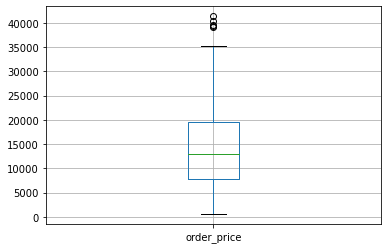

In [160]:
outlier_data.boxplot(column='order_price')

Using the formula of IQR shown before, we are going to inspect those values and see if there is a mistake or it is correct

$$Outlier_{\text{upper}} > Q3 + 1.5*IQR$$
$$Outlier_{\text{lower}} < Q1 - 1.5*IQR$$

In [161]:
outlier_data.order_price.describe()

count      500.000000
mean     14029.690000
std       7966.772369
min        580.000000
25%       7770.000000
50%      12910.000000
75%      19521.250000
max      41385.000000
Name: order_price, dtype: float64

In [162]:
q1 = outlier_data.order_price.quantile(0.25)
q3 = outlier_data.order_price.quantile(0.75)
IQR = q3 - q1

In [163]:
upper_boundary = q3 + (1.5*IQR)
lower_boundary = q1 - (1.5*IQR)

Using the formula we realize that there are some clients that are quite far from the nearest warehouse. That is why we want to make a closer look to those values

In [164]:
lower_outlier_price = outlier_data[outlier_data.order_price < lower_boundary]
len(lower_outlier_distance)

0

There are not values below the lower boundary

In [165]:
upper_outlier_distance = outlier_data[outlier_data.order_price > upper_boundary]
len(upper_outlier_distance)

5

As we found 5 values above the upper boundary we proceed to recalculate the price of these orders

In [166]:
shopping_list = outlier_data.shopping_cart[outlier_data.order_price < upper_boundary].to_list() # Get the rows that were wrangled
price_list = outlier_data.order_price[outlier_data.order_price < upper_boundary].to_list() # Get the rows that were wrangled

products_list = [] # Empty list to identify all the different products that the store sells
equations = [] # Empty list to store all the equations to solve the linear solution
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i) # Find every text between (' and ',
    
    for product in products: # for every product found by the Regular Expression
        if product not in products_list: # Build a list with all the different products found
            products_list.append(product)   
        

for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    equation = [0]*10 # Build a list of 10 elements all of them 0
    for j in range(len(products)): # For every element in products
        for k in range(len(products_list)): # for every element in products_list
            if products[j] == products_list[k]: # If the elements are equal
                equation[k] = quantity[j] # Assign the quantity of each product to the list equantion
    
    equations.append(equation) # Append all the equations together           

Now that we already have the equations and the solution to it, we can procced to solve the problem using the lubrary numpy

In [167]:
eq = np.array(equations[:10])
res = np.array(price_list[:10])
solution = np.linalg.solve(eq, res)

And construct a dictionary `product_price` where we can store the price of each product

In [168]:
product_price = {}
for i in range(len(solution)):
    product_price[products_list[i]] = round(solution[i])

product_price

{'Toshika 750': 4320.0,
 'Lucent 330S': 1230.0,
 'Alcon 10': 8950.0,
 'iAssist Line': 2225.0,
 'pearTV': 6310.0,
 'Olivia x460': 1225.0,
 'Candle Inferno': 430.0,
 'Universe Note': 3450.0,
 'iStream': 150.0,
 'Thunder line': 2180.0}

With this dictionary, now we know the price of each product. So we can verify if the outliers are wrong values or atypical orders

In [169]:
shopping_list = outlier_data.shopping_cart[outlier_data.order_price > upper_boundary].to_list()

calculated_outliers = []
for i in shopping_list: # For every row of shopping list
    products = re.findall('\(\'(.*?)\'\,', i)  # Find every text between (' and ',
    quantity = re.findall('\'\,\ (.*?)\)', i)  # Find every text between ', and )
    quantity = [int(i) for i in quantity] # convert the text founf by the regular expression to integer
    
    total = 0
    for j in range(len(products)): # For every element in products
        for k in product_price: # for every element in products_list
            if products[j] == k:
                total += product_price[k]*quantity[j]
    
    calculated_outliers.append(total)

calculated_outliers

[41385.0, 39645.0, 40390.0, 39200.0, 39460.0]

In [170]:
original_outliers = outlier_data.order_price[outlier_data.order_price > upper_boundary].to_list()

In [171]:
original_outliers == calculated_outliers

True

And as we found that these two lists are equal we assume that the outliers are atypical big orders and are not wrong values

Now that the dataframe is wrangled, we proceed to export the solution to the new cav file

In [61]:
outiler_data.to_csv('./output/outlier_data_solution.csv')

### References

https://www.quora.com/Is-year-a-quantitative-or-categorical-variable

https://stackoverflow.com/questions/15126679/plot-key-count-per-unique-value-count-in-pandas

https://datatofish.com/if-condition-in-pandas-dataframe/

https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns/34023971

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html

https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe

https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe

https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

https://towardsdatascience.com/left-join-with-pandas-data-frames-in-python-c29c85089ba4

https://stackoverflow.com/questions/59879720/find-min-value-column-and-min-value-column-name-in-python-dataframe

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/